NÚMERO DE VEHÍCULOS UTILIZADOS EMPRESA
57
Set parameter TimeLimit to value 1380
Set parameter LogFile to value "gurobi.log"
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1045 rows, 117526 columns and 351534 nonzeros
Model fingerprint: 0x75f2b95e
Variable types: 0 continuous, 117526 integer (117526 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Presolve removed 50 rows and 1069 columns
Presolve time: 0.60s
Presolved: 995 rows, 116457 columns, 232914 nonzeros
Variable types: 0 continuous, 116457 integer (116457 binary)

Root relaxation: objective 4.900000e+01, 4092 iterations, 0.68 seconds (1.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

/Users/luismiguel/Envs/gurobienv/lib/python3.8/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


NÚMERO DE VEHÍCULOS UTILIZADOS MODELO
49


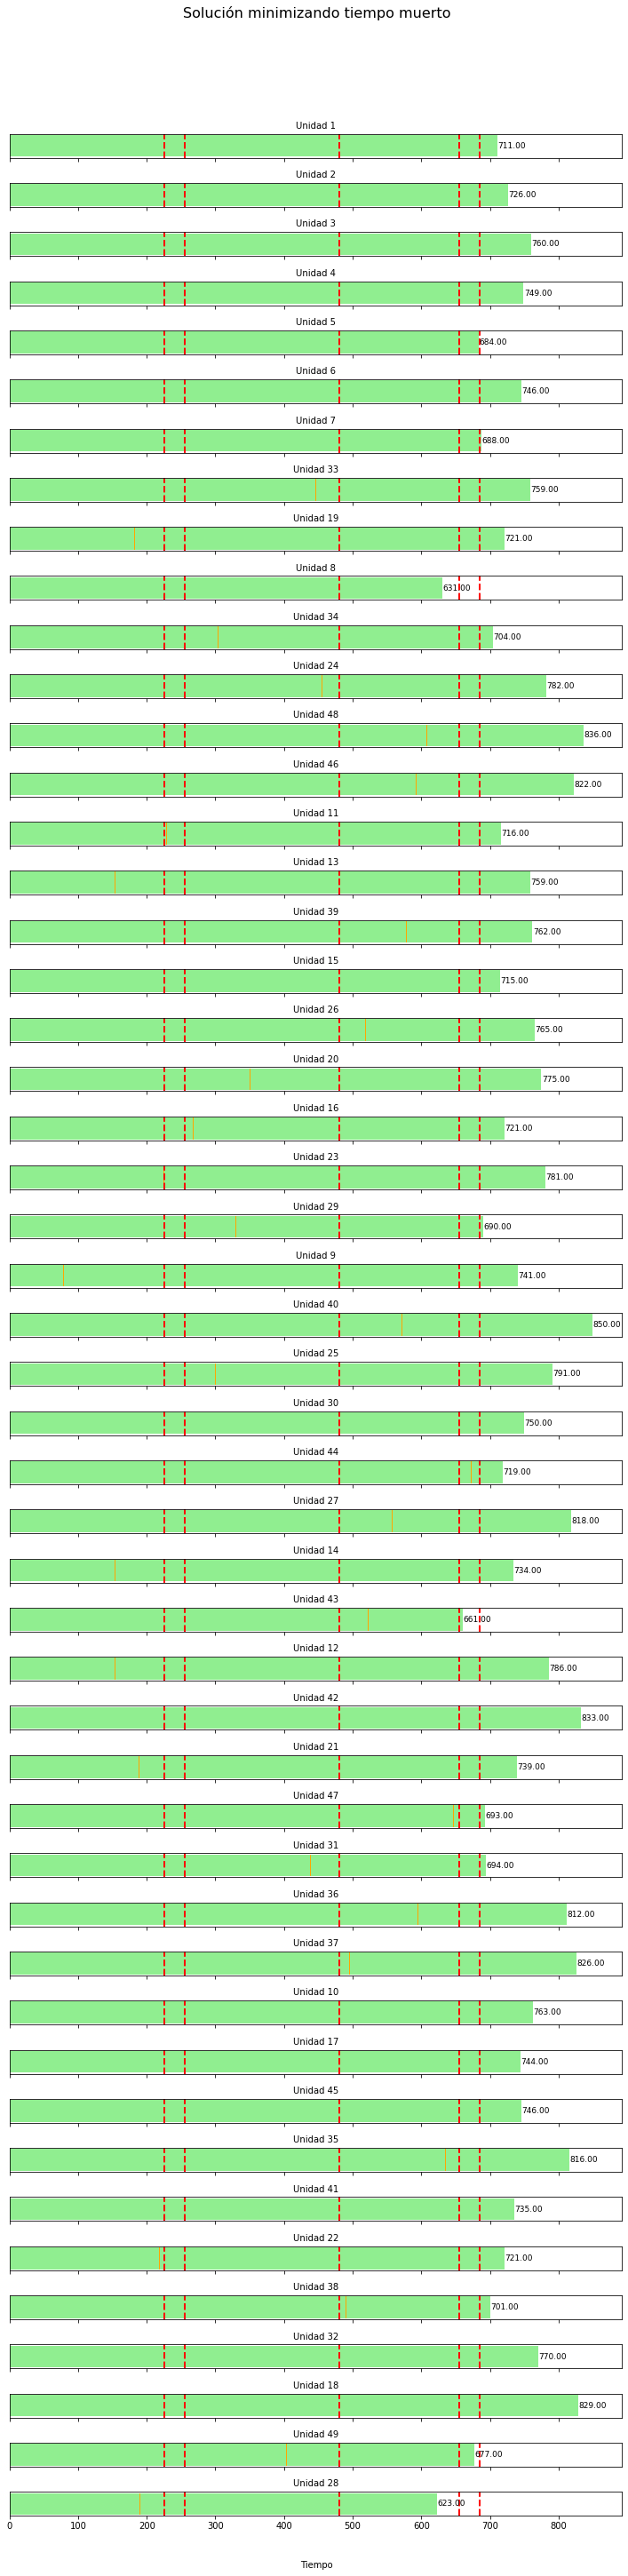

In [3]:
# LMT : Usaremos este esquema para guardar archivos
# LMT : Tres carpetas principales: src/ data/ sol/
# LMT : Para almacenar código, datos y soluciones
# LMT : Cada proyecto de código (Python o C++) irá en una carpeta individual, adentro de src/
# LMT : todos los datos se leen desde carpetas adentro de data/
# LMT : todas las respuestas se escriben en carpetas adentro de sol/
# LMT : Adicionalmente, los módulos de DataProcessing irán directamente dentro de la carpeta con este cuaderno
# LMT : (es decir, estoy quitando la carpeta "src" intermedia en este caso)
# LMT : (hay que actualizar también el archivo read_data.py)
import DataProcessing.read_data as rd
import DataProcessing.transform_data as td
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataProcessing.read_data import lectura_alimentadora_norte
from DataProcessing.transform_data import hora_a_minutos
from DataProcessing.read_data import crear_dataframe_resultado
from DataProcessing.read_data import lectura_alimentadora_norte
from DataProcessing.read_data import crear_dataframe_resultado

# LMT : Desde aquí cargaremos los parámetros
import Params

ruta_excel = '../../data/alimentadores_norte_1/Todo.xlsx'
ruta="Ordinario"
df = lectura_alimentadora_norte(ruta_excel,ruta)
print("NÚMERO DE VEHÍCULOS UTILIZADOS EMPRESA")
print(max(df["COD. OP."]))
# LMT : Para evitar en el futuro problemas como el que se presentó con el dataset de todas las rutas,
# LMT : mejor usaremos por defecto -1 para el nodo final
def obtener_diccionario_costo_completo(df, nodo_inicio=0, nodo_final=-1):
    """
    Devuelve un diccionario {(origen, destino): costo} incluyendo arcos de depósito.
    - nodo_inicio: número del depósito de salida (por defecto 0)
    - nodo_final: número del depósito de llegada (por defecto 500)
    """
    costos = {}
    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            # LMT : En el criterio de compatibilidad estoy incluyendo el parámetro de tiempo mínimo de espera
            if row_j['HORA_SALIDA'] > row_i['HORA_LLEGADA'] + Params.T_MIN_ESPERA:
                costos[(int(row_i['ORD']), int(row_j['ORD']))] = 0
        # Arco desde depósito de inicio
        costos[(nodo_inicio, int(row_i['ORD']))] = 1
        # Arco hacia depósito final (500)
        costos[(int(row_i['ORD']), nodo_final)] = 0
    return costos


costos = obtener_diccionario_costo_completo(df)

arcos=costos.keys()
N = df['ORD'].unique()

capacidad=max(df["COD. OP."])

import gurobipy as gp
from gurobipy import GRB


m1 = gp.Model('Asignacion-Flota-V1')
# Terminar al alcanzar un Gap del 10%
# LMT : Creo que para el modelo sencillo se puede dejar el gap en el valor por defecto de 0%
# m1.Params.MIPGap = 0.10
m1.setParam('OutputFlag', 1)
# LMT : Creo que para el modelo sencillo no se necesitan fijar estos parámetros
# Enfocar estrategia en mejorar la cota dual
# m1.Params.MIPFocus = 3

# LMT : Creo que para el modelo sencillo no se necesitan fijar estos parámetros
# Fijar generación muy agresiva de cortes
# m1.Params.Cuts = 3

# Terminar luego de 180 segundos
m1.Params.TimeLimit = 1380

x = m1.addVars(arcos,vtype=GRB.BINARY,name='x')
# Update model to integrate new variables
m1.setParam('LogFile', 'gurobi.log')

m1.setObjective(gp.quicksum(costos[i,j]*x[i,j] for i,j in arcos),GRB.MINIMIZE)

# LMT: cambié la variable n por la variable i en el siguiente lazo
m1.addConstrs((x.sum(i,'*') == 1 for i in N), name=f"Constraints")
m1.addConstrs((x.sum('*',i)-x.sum(i,'*')==0 for i in N ),name=f'conservacion')

m1.addConstr((x.sum(0,'*') <= capacidad), name=f"Constraints_2")
m1.write('Modelo.lp')

m1.optimize()


df=lectura_alimentadora_norte(ruta_excel,ruta)
base=crear_dataframe_resultado(m1,df)
#print(base)
import os
nombre_archivo = os.path.basename(ruta_excel)
circuito = os.path.splitext(nombre_archivo)[0]
# LMT : Ajusto el nombre del siguiente archivo (ruta) como se indica en mi primer comentario
ruta = f"../../sol/alimentadores_norte_1/{circuito}-sol.xlsx"
 # Cambia esta ruta a donde quieras guardar

# Guardar como archivo Excel
base.to_excel(ruta, index=False)

print("NÚMERO DE VEHÍCULOS UTILIZADOS MODELO")
print(max(base["COD. OP."]))

def visualizar(base):
    """
    Función para graficar los tiempos de andén y de viaje por unidad operativa.
    
    Parámetro:
    - base: DataFrame que debe contener las columnas:
      'TIEMPO EN ANDÉN', 'HORA_LLEGADA', 'HORA_SALIDA', 'COD. OP.'
    """
    base = base.copy()  # para no modificar el df original
    
    base['ANDEN_MINUTOS'] = base['TIEMPO EN ANDÉN']
    base['TIEMPO_VIAJE'] = base['HORA_LLEGADA'] - base['HORA_SALIDA']
    #print(base['ANDEN_MINUTOS'])

    # Umbral de color para el tiempo en andén
    valor_umbral = 100

    # Unidades únicas
    unidades = base['COD. OP.'].unique()

    # Crear subgráficos por unidad
    fig, axs = plt.subplots(len(unidades), 1, figsize=(10, len(unidades)*1/1.15), sharex=True)

    # Líneas verticales de referencia
    lineas_verticales = [225, 255, 480, 655, 685]

    resultados = []
    contadorAux = 1

    for i, unidad in enumerate(unidades):
        base_unidad = base[base['COD. OP.'] == unidad]
        
        Type = []
        Time = []
        Colors = []
        
        for _, row in base_unidad.iterrows():
            if not pd.isna(row['ANDEN_MINUTOS']):
                Type.append('A1')
                Time.append(row['ANDEN_MINUTOS'])
                Colors.append('orange' if row['ANDEN_MINUTOS'] <= valor_umbral else 'skyblue')
            Type.append('A2')
            Time.append(row['TIEMPO_VIAJE'])
            Colors.append('lightgreen')
        
        data = pd.DataFrame({
            "Type": Type,
            "Time": Time,
            "Colors": Colors
        })

        if contadorAux <= 15:
            resultados.append(data)
        
        contadorAux += 1
        left = 0
        bar_height = 0.3
        
        for _, row in data.iterrows():
            axs[i].barh(y=0, width=row['Time'], left=left, color=row['Colors'], height=bar_height)
            left += row['Time']
        
        total_time = left
        axs[i].text(left + 0.5, 0, f'{total_time:.2f}', va='center', fontsize=9)
        axs[i].set_yticks([])
        axs[i].set_title(f'Unidad {unidad}', fontsize=10)

        for x_value in lineas_verticales:
            axs[i].axvline(x=x_value, color='red', linestyle='--', linewidth=2)

    fig.text(0.5, 0.04, 'Tiempo', ha='center')
    fig.suptitle('Solución minimizando tiempo muerto', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

visualizar(base)